Symbolic Unconditional Music Generator
=====

In [1]:
#Important Imports can add more as needed
#Easier Importing you can type "pip install -r imports.txt" in the terminal
#these are imports from workbook3
import glob
import random
from typing import List
from collections import defaultdict, Counter

import numpy as np
from numpy.random import choice

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from symusic import Score
from miditok import REMI, TokenizerConfig

#additional imports for the LSTM model
from miditok import TokSequence
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 

## 1. Load MIDI Files

In [2]:
#random seed can be changed to get different results, default its 42
#from CSE_153R Homework 3(Spring 2025)
random.seed(42)

#Loading the music data
#first is popular pop songs I enjoy
#midi_files = glob('data/*.mid')
#same midi file data We have trained on for Assigment 1 Task 1
#midi_files = glob('Assignment1(Task1_midis)/*.midi')
#Lofi music data I got from kaggle
midi_files = glob.glob('Lo-Fi/*.mid')
#print(midi_files)
len(midi_files)
    

93

### We are focusing on Lofti Music with just one instrument: Grand Piano, which is very commonly used in Lofti music. Our whole training data uses only Grand Piano, which is embedded as program 0 in MIDI files.

In [3]:
def extract_instrument_stats(midi_files):
    program_counts = defaultdict(int)
    
    for file_path in midi_files:
        score = Score(file_path)
        for track in score.tracks:
            # Get program number (0-127)
            program = track.program
            # Count notes in this track
            note_count = len(track.notes)
            program_counts[program] += note_count
    
    return program_counts

instrument_stats = extract_instrument_stats(midi_files)

# Sort if training data contains more than 1 programs, in this case no.
top_programs = sorted(instrument_stats.items(), key=lambda x: x[1], reverse=True)[:4]

print("\ninstrument programs used by training data:")
for i, (program, count) in enumerate(top_programs, 1):
    print(f"{i}. Program {program}: {count} notes")


instrument programs used by training data:
1. Program 0: 4060 notes


# 2. Training A Tokenizer With REMI Method
 - Configures MIDI tokenizer with simplified settings：
 
     - Ignore how hard notes are pressed

     - Don't treat chords as single items

     - Ignore instrument types (since we know they are all grand piano)

 - Initializes REMI tokenizer

 - Trains tokenizer on the MIDI files with 1000-token vocabulary

In [4]:
config = TokenizerConfig(num_velocities=1, use_chords=False, use_programs=False)
tokenizer = REMI(config)
tokenizer.train(vocab_size=1000, files_paths=midi_files)

### Example of tokenization on the first MIDI file

In [5]:
# e.g.:
midi = Score(midi_files[0])
tokens = tokenizer(midi)[0].tokens
tokens[:10]

['Bar_None',
 'Position_0',
 'Pitch_47',
 'Velocity_127',
 'Duration_0.3.8',
 'Pitch_54',
 'Velocity_127',
 'Duration_0.3.8',
 'Pitch_62',
 'Velocity_127']

# 3. Extracting The Notes

 - Define helper function that extracts pitch numbers from tokenized MIDI

 - Aggregate all notes from all MIDI files into single list

In [6]:
def note_extraction(midi_file):
    score = Score(midi_file)
    tokens = tokenizer(score)[0].tokens
    pitches = []
    #only grabs the number if the starting word is "Pitch"
    for token in tokens:
        if token.startswith('Pitch'):
            # Extract the note number from the token
            note_number = int(token.split('_')[1])
            pitches.append(note_number)
    return pitches

#Getting the list of notes as Corpus
#create an Array of Notes from each midi file
notes = []
total_notes = 0
for file in midi_files:
    Corpus = note_extraction(file)
    notes += Corpus
    total_notes += sum(Corpus)
print("Each midifile notes: ", notes)
print("length of MifiFile notes: ", len(notes))
print("Total notes in the dataset: ", total_notes)

Each midifile notes:  [47, 54, 62, 69, 73, 47, 59, 62, 66, 69, 52, 59, 62, 67, 71, 74, 50, 61, 66, 69, 76, 47, 54, 62, 69, 73, 47, 59, 62, 66, 69, 52, 59, 62, 67, 71, 74, 50, 61, 66, 69, 76, 47, 54, 62, 69, 73, 45, 69, 72, 64, 83, 86, 64, 67, 76, 52, 64, 67, 71, 86, 78, 66, 76, 71, 79, 45, 69, 72, 64, 83, 86, 64, 67, 76, 52, 64, 67, 71, 86, 78, 66, 76, 79, 43, 62, 67, 71, 78, 71, 67, 62, 53, 65, 69, 72, 76, 74, 79, 67, 43, 62, 67, 71, 78, 71, 67, 62, 53, 65, 69, 72, 76, 74, 79, 67, 41, 60, 65, 69, 76, 50, 62, 65, 69, 72, 52, 64, 67, 71, 79, 84, 71, 46, 65, 70, 73, 75, 53, 65, 68, 72, 53, 65, 68, 72, 77, 46, 65, 70, 73, 77, 82, 46, 65, 70, 73, 75, 53, 65, 68, 72, 53, 65, 68, 72, 77, 46, 65, 70, 73, 77, 82, 36, 60, 64, 55, 69, 38, 62, 65, 57, 67, 40, 64, 57, 59, 74, 43, 55, 59, 62, 64, 69, 45, 64, 69, 72, 79, 83, 64, 67, 48, 64, 67, 72, 86, 60, 69, 47, 66, 71, 74, 81, 41, 60, 65, 69, 76, 79, 50, 62, 65, 69, 72, 52, 64, 67, 71, 74, 41, 60, 65, 69, 76, 41, 60, 65, 69, 76, 79, 50, 62, 65, 6

# 4. Building the LSTM Model

### Preparation:
 - Set training sequence

 - Prepare input-target pairs for LSTM training
 
 - Convert data to PyTorch tensors

In [7]:
seq_length = 32  # Number of notes in each input sequence
step = 1

# Create input/output pairs
inputs = []
targets = []
for i in range(0, len(notes) - seq_length, step):
    inputs.append(notes[i:i+seq_length])
    targets.append(notes[i+seq_length])

inputs = torch.tensor(inputs, dtype=torch.long)
targets = torch.tensor(targets, dtype=torch.long)

### Define LSTM Model
 - Define architectures
 
 - Use only last LSTM output for prediction

In [8]:
class MusicLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # Use only the last output for prediction
        return out, hidden

# 5. Setting Up The Training

### Initiallize Model
 - vocabulary size = maximum MIDI pitch

 - use GPU if available

 - use Adam optimizer with 0.01 learning rate
 
 - Use cross-entropy loss

In [9]:
vocab_size = max(notes) + 1  # Or len(set(notes))
model = MusicLSTM(vocab_size)
#default use GPU unless not avaliable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
#chnage the learning rate as desired
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

### Training Loop

In [10]:
num_epochs = 100
batch_size = 64
loss_history = []
for epoch in range(num_epochs):
    permutation = torch.randperm(inputs.size(0))
    epoch_loss = 0
    for i in range(0, inputs.size(0), batch_size):
        idx = permutation[i:i+batch_size]
        batch_x = inputs[idx].to(device)
        batch_y = targets[idx].to(device)

        optimizer.zero_grad()
        outputs, _ = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    loss_history.append(epoch_loss)

Epoch 1/100, Loss: 266.1464
Epoch 2/100, Loss: 238.4171
Epoch 3/100, Loss: 229.1469
Epoch 4/100, Loss: 221.4269
Epoch 5/100, Loss: 215.1904
Epoch 6/100, Loss: 208.7875
Epoch 7/100, Loss: 202.1524
Epoch 8/100, Loss: 195.6378
Epoch 9/100, Loss: 189.1198
Epoch 10/100, Loss: 183.3956
Epoch 11/100, Loss: 177.5901
Epoch 12/100, Loss: 171.8522
Epoch 13/100, Loss: 166.2743
Epoch 14/100, Loss: 160.9351
Epoch 15/100, Loss: 155.5690
Epoch 16/100, Loss: 150.5543
Epoch 17/100, Loss: 144.9986
Epoch 18/100, Loss: 140.0476
Epoch 19/100, Loss: 135.3172
Epoch 20/100, Loss: 130.4922
Epoch 21/100, Loss: 125.9932
Epoch 22/100, Loss: 121.2239
Epoch 23/100, Loss: 116.4368
Epoch 24/100, Loss: 112.0489
Epoch 25/100, Loss: 107.8293
Epoch 26/100, Loss: 103.4504
Epoch 27/100, Loss: 98.8266
Epoch 28/100, Loss: 95.4203
Epoch 29/100, Loss: 91.6726
Epoch 30/100, Loss: 87.2847
Epoch 31/100, Loss: 83.5853
Epoch 32/100, Loss: 79.7614
Epoch 33/100, Loss: 76.7714
Epoch 34/100, Loss: 72.8955
Epoch 35/100, Loss: 69.6438
Epo

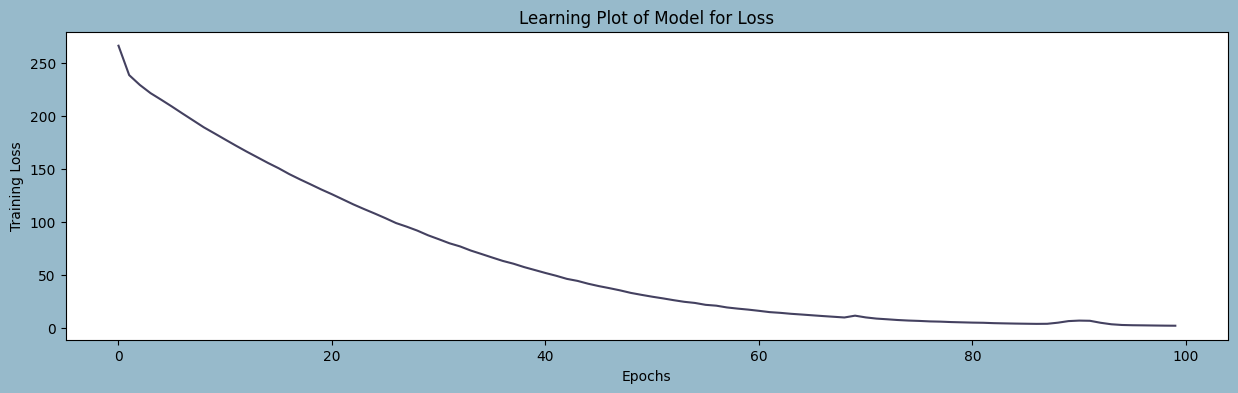

In [11]:
#Plotting the learnings 

plt.figure(figsize=(15,4), facecolor="#97BACB")
plt.plot(loss_history, color="#444160")
plt.title("Learning Plot of Model for Loss")
plt.ylabel("Training Loss")
plt.xlabel("Epochs")
plt.show()

# 6. Generate Music

### MIDI Export Helper Functions

 - `note_sequence_to_midi()` : creates a single-instrument midi

 - `multi_instrument_sequence_to_midi()` : creates a multi-instrument midi by creating seperate tracks for each instrument

 - `multi_instrument_random_sequence_to_midi()` : creates a multi-instrument midi by assigning random programs to notes

 - Lo-Fi specific settings:

     - Slower tempo (750000 μs/beat ≈ 80 BPM)

     - Longer note durations

In [12]:
#change the tempo for a slower BPM
#increase note_length for longer notes, more lofi feel

def note_sequence_to_midi(note_sequence, filename, velocity=64, tempo=750000, note_length=240, program=24):
    import mido
    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo))
    track.append(mido.Message('program_change', program=program, time=0))
    
    for note in note_sequence:
        track.append(mido.Message('note_on', note=note, velocity=velocity, time=0))
        track.append(mido.Message('note_off', note=note, velocity=velocity, time=note_length))
    mid.save(filename)

In [13]:
# I had AI generate a function that allowed me to create a midi file with multiple instruments
# instead of my default one that only allows one single instrument
def multi_instrument_sequence_to_midi(note_sequences, programs, filename, velocity=64, tempo=750000, note_length=240):
    """
    note_sequences: list of lists, each sublist is a sequence of notes for one instrument
    programs: list of program numbers (0-127), one for each instrument
    """
    import mido
    mid = mido.MidiFile()
    # I am guessing here is where it iterates through each program/instrument
    for channel, (notes, program) in enumerate(zip(note_sequences, programs)):
        track = mido.MidiTrack()
        mid.tracks.append(track)
        track.append(mido.MetaMessage('set_tempo', tempo=tempo))
        track.append(mido.Message('program_change', program=program, channel=channel, time=0))
        for note in notes:
            track.append(mido.Message('note_on', note=note, velocity=velocity, time=0, channel=channel))
            track.append(mido.Message('note_off', note=note, velocity=velocity, time=note_length, channel=channel))
    mid.save(filename)

In [14]:
# Modified the previous function so that instead of looping through the given list of programs, choose a random program to assign.
# Since it is not practical to have instruments to play just one note every few seconds in real music
def multi_instrument_random_sequence_to_midi(note_sequences, programs, filename, velocity=64, tempo=750000, note_length=240):
    """
    note_sequences: list of lists, each sublist is a sequence of notes for one instrument
    programs: list of program numbers (0-127), one for each instrument
    """
    import mido
    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)
    
    # Set initial tempo
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    
    # Use channel 0 for all notes but change program per note
    channel = 0
    current_time = 0

    # Have instruments play for random number of notes (from 1 to 5)
    max_count = 0
    curr_count = 0
    
    for notes in note_sequences:
        for note in notes:

            # Reset the count for each new instrument chosen
            if curr_count >= max_count:
                max_count = random.randint(1,5)
                curr_count = 0        
                # Choose random program for the next "max_count" number of notes
                program = random.choice(programs)
            
            # Add program change (delta time from previous event)
            track.append(mido.Message('program_change', program=program, 
                                     time=current_time, channel=channel))
            current_time = 0  # Reset delta time after program change
            
            # Add note events
            track.append(mido.Message('note_on', note=note, velocity=velocity, 
                                     time=current_time, channel=channel))
            track.append(mido.Message('note_off', note=note, velocity=velocity, 
                                     time=note_length, channel=channel))
            
            # Next event starts after note ends
            current_time = 0  # Reset for next program change
            curr_count += 1
    
    mid.save(filename)

### Music Generation Process:

1. Starts with seed sequence (first 32 notes)

2. Autoregressively predicts next notes

3. Uses probabilistic sampling instead of greedy algorithm

4. Generates 1024-note sequence

### Multi-instrument arrangement Option 1 (the one we submitted):

1. Splits notes into 7 parallel sequences

2. Assigns Lo-Fi appropriate instruments:

         - 4: Electric Piano

         - 5: Chorused Piano

         - 6: Harpsichord

         - 11: Vibraphone

         - 24: Acoustic Guitar

         - 32: Acoustic Bass

         - 48: Strings

3. Exports final MIDI file

### Multi-instrument arrangement Option 2:

Same as previous except the instruments:

 - 0: Grand Piano

 - 4: Electric Piano

 - 11: Vibraphone

 - 24: Acoustic Guitar

 - 32: Acoustic Bass

Since this version has randomness, we chose the instruments that had the best performance after comparing a dozen of attempts

In [15]:
def generate_sequence(model, seed, length=1024):
    model.eval()
    generated = list(seed)
    input_seq = torch.tensor(seed, dtype=torch.long).unsqueeze(0).to(device)
    hidden = None
    for _ in range(length):
        output, hidden = model(input_seq, hidden)
        probs = torch.softmax(output, dim=-1).detach().cpu().numpy().flatten()
        next_note = np.random.choice(np.arange(vocab_size), p=probs)
        generated.append(next_note)
        input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_note]], device=device)], dim=1)
    return generated

seed = notes[:seq_length]
generated_notes = generate_sequence(model, seed, length = 1024)

#change this to match the amount of instrument you want to use
num_instruments = 7 
length = len(generated_notes) // num_instruments

# Truncate to a multiple of num_instruments to avoid uneven lists
trimmed_length = length * num_instruments
trimmed_notes = generated_notes[:trimmed_length]

# Group notes by time step: each sublist is [note1, note2, note3] for that tick
ticks = [trimmed_notes[i*num_instruments:(i+1)*num_instruments] for i in range(length)]

# Transpose: now each instrument gets its own list of notes
note_sequences = list(map(list, zip(*ticks)))

## Generate Multi-instrument piece

# Save generated notes as a MIDI file using midi_utils
output_midi_path = "Lo-Fi_Generated_Music_Multi_Instrument.mid"
#multi_instrument_sequence_to_midi(note_sequences,[4, 5, 6, 11, 24, 32, 48], output_midi_path)
#multi_instrument_sequence_to_midi(note_sequences,[4, 11, 32], output_midi_path)
#print(f"Generated Multi-instrument MIDI saved as {output_midi_path}")

## Generate Single instrument piece, using Grand Piano
output_midi_path = "Lo-Fi_Generated_Music_Single_Instrument_100_epoch.mid"
note_sequence_to_midi(generated_notes, output_midi_path, program=0)
print(f"Generated Single-instrument MIDI saved as {output_midi_path}")

## Generate Multi-instrument piece with randomness
output_midi_path = "Lo-Fi_Generated_Music_Random_Multi_Instrument.mid"
#multi_instrument_random_sequence_to_midi(note_sequences,[0, 4, 11, 24, 32], output_midi_path)
#print(f"Generated Multi-instrument MIDI with randomness saved as {output_midi_path}")

Generated Single-instrument MIDI saved as Lo-Fi_Generated_Music_Single_Instrument_100_epoch.mid


## Comparison to Music Generation using Unigram and Bigram

This is the same method that we used for Homework 3. The following are code taken straight from homework 3 with small modifications.

### 1. Frequency Counting and Probability Calculation

In [16]:
# Unigram model: Count single note frequencies
unigram_counts = Counter(notes)

# Bigram model: Count note pairs
bigram_counts = defaultdict(Counter)
for i in range(len(notes) - 1):
    current_note = notes[i]
    next_note = notes[i + 1]
    bigram_counts[current_note][next_note] += 1

In [17]:
# Unigram probabilities
total_notes = sum(unigram_counts.values())
unigram_probs = {note: count/total_notes for note, count in unigram_counts.items()}

# Bigram probabilities
bigram_probs = defaultdict(dict)
for current_note, next_counts in bigram_counts.items():
    total = sum(next_counts.values())
    bigram_probs[current_note] = {next_note: count/total 
                                for next_note, count in next_counts.items()}

### 2. Helper Methods for Music Generation Functions

 - `generate_unigram_sequence()` : Generate notes using unigram probabilities

 - `generate_bigram_sequence()` : Generate notes using bigram probabilities

In [18]:
def generate_unigram_sequence(length=1024):
    notes_list = list(unigram_probs.keys())
    probs = list(unigram_probs.values())
    return np.random.choice(notes_list, size=length, p=probs).tolist()

def generate_bigram_sequence(seed_note, length=1024):
    sequence = [seed_note]
    current_note = seed_note
    
    for _ in range(length - 1):
        # Get probabilities for next note
        if current_note in bigram_probs:
            next_notes = list(bigram_probs[current_note].keys())
            next_probs = list(bigram_probs[current_note].values())
            next_note = random.choices(next_notes, weights=next_probs, k=1)[0]
        else:
            # Use unigram if bigram not found
            next_note = random.choices(list(unigram_probs.keys()), weights=list(unigram_probs.values()), k=1)[0]
        
        sequence.append(next_note)
        current_note = next_note
    
    return sequence

### Music Generation Single-Instrument and Multi-Instrument for both Unigram and Bigram

In [19]:
# Generate sequences
unigram_notes = generate_unigram_sequence(1024)
bigram_notes = generate_bigram_sequence(notes[0], 1024)

## Generate Single instrument piece, using Grand Piano
output_midi_path = "Lo-Fi_Generated_Music_Single_unigram_music.mid"
#note_sequence_to_midi(unigram_notes, output_midi_path, program=0)
#print(f"Generated Single-instrument MIDI using Unigram saved as {output_midi_path}")

## Generate Single instrument piece, using Grand Piano
output_midi_path = "Lo-Fi_Generated_Music_Single_bigram.mid"
#note_sequence_to_midi(bigram_notes, output_midi_path, program=0)
#print(f"Generated Single-instrument MIDI using Bigram saved as {output_midi_path}")

In [20]:
def split_notes(sequence, num_instruments=4):
    """Split sequence into multiple instruments"""
    return [sequence[i::num_instruments] for i in range(num_instruments)]

multi_unigram = split_notes(unigram_notes)
multi_bigram = split_notes(bigram_notes)

## Generate Multi-instrument piece
output_midi_path = "Lo-Fi_Generated_Music_Multi_unigram.mid"
#multi_instrument_sequence_to_midi(multi_unigram,[4, 5, 6, 11, 24, 32, 48], output_midi_path)
#print(f"Generated Multi-instrument MIDI using Unigram saved as {output_midi_path}")

## Generate Multi-instrument piece
output_midi_path = "Lo-Fi_Generated_Music_Multi_bigram.mid"
#multi_instrument_sequence_to_midi(multi_bigram,[4, 5, 6, 11, 24, 32, 48], output_midi_path)
#print(f"Generated Multi-instrument MIDI using Bigram saved as {output_midi_path}")